# Intelligent Systems. Hands-on 3
# Introduction

We have used the base document [here](http://rpubs.com/rgcmme/IS-HO3) and we have added our analysis at the end of the document.

The goal of this document is to show how to perform different annotations (word, sentence, part-of-speech, and Penn Treebank parse) over text documents using the **openNLP** (natural language processing) and the **tm** (text mining) packages in R.

# Preparation
## Check working directory
Check the working directory with ```wd```. If it is not the one where your data are located, change it with ```setwd```.

In [1]:
# getwd()

In [2]:
# setwd("./HO3")

## Load libraries
Now we load the required libraries. Only a couple of things to mention:

- Using the annotate function of the openNLP package may require to explicitly include the package name (i.e., ```NLP::annotate```) due to a name clash with ggplot2
- Need to change the memory allocated to Java to avoid out-of-memory problems

In [3]:
# Needed for OutOfMemoryError: Java heap space 
library(rJava)
#.jinit(parameters="-Xmx8g")
# If there are more memory problems, invoke gc() after the POS tagging

library(NLP) 
library(openNLP) 
library(openNLPmodels.en)
library(tm)
library(stringr)

# Auxiliary functions
## getAnnotationsFromDocument
```getAnnotationsFromDocument``` returns annotations for the text document: word, sentence, part-of-speech, and Penn Treebank parse annotations.

As an alternative, the koRpus package uses TreeTagger for POS tagging.

In [4]:
getAnnotationsFromDocument = function(doc){
  x=as.String(doc)
  sent_token_annotator <- Maxent_Sent_Token_Annotator()
  word_token_annotator <- Maxent_Word_Token_Annotator()
  pos_tag_annotator <- Maxent_POS_Tag_Annotator()
  y1 <- annotate(x, list(sent_token_annotator, word_token_annotator))
  y2 <- annotate(x, pos_tag_annotator, y1)
#  parse_annotator <- Parse_Annotator()
#  y3 <- annotate(x, parse_annotator, y2)
  return(y2)  
} 

# getAnnotatedMergedDocument
```getAnnotatedMergedDocument``` returns the text document merged with the annotations.

In [5]:
getAnnotatedMergedDocument = function(doc,annotations){
  x=as.String(doc)
  y2w <- subset(annotations, type == "word")
  tags <- sapply(y2w$features, '[[', "POS")
  r1 <- sprintf("%s/%s", x[y2w], tags)
  r2 <- paste(r1, collapse = " ")
  return(r2)  
} 

# getAnnotatedPlainTextDocument
```getAnnotatedPlainTextDocument``` returns the text document along with its annotations in an ```AnnotatedPlainTextDocument```.

In [6]:
getAnnotatedPlainTextDocument = function(doc,annotations){
  x=as.String(doc)
  a = AnnotatedPlainTextDocument(x,annotations)
  return(a)  
} 

# detectPatternOnDocument --> <font color='red'> Modified to include all matches</font> 
```detectPatternOnDocument``` returns the pattern detected on an ```AnnotatedPlainTextDocument```.

We have modified this function to include all matches in a document for the names annotation, not only the first one.

In [7]:
detectPatternOnDocument_old <- function(doc, pattern) {
  x=as.String(doc)
  res=str_match(x,pattern)
  
  if (length(res)==1){
    return (res)
  } else {
    if (all(is.na(res[,2:length(res)])))
      return (NA)
    else {
      ret=list()
      for (i in 2:length(res)){
        ret = paste(ret,res[i])
      }
      return(ret)
    }
  }
}

In [8]:
detectPatternOnDocument <- function(doc, pattern) {
  x=as.String(doc)
  res=str_match_all(x,pattern)
  if (length(res[[1]])==0){
    return (NA)
  } else {
      if (all(is.na(res[2:length(res)]))){
          return (NA)
      }
      else {
            ret=list()
            for (k in 1:length(res)){
              for (i in 1:length(res[[k]][,1])){
                            if (i>1){
                      ret = paste(ret,",")
                  }
                  for (j in 2:(length(res[[1]][1,]))){
                      ret = paste(ret,res[[k]][i,j])
                  }
              }
            }
    return(ret)
    }
  }
}

# detectPatternOnDocumentWithContext
```detectPatternOnDocumentWithContext``` returns the pattern detected on an ```AnnotatedPlainTextDocument``` with some context.

In [9]:
detectPatternOnDocumentWithContext <- function(doc, pattern) {
  txt=as.String(doc)
  number=50
  coord=str_locate(txt,pattern)
  res3=substr(txt,coord[1]-number,coord[2]+number)
  return (res3)
}

# detectPatternsInCorpus --> <font color='red'> Modified to call the new function </font> 
```detectPatternsInCorpus``` returns a data frame with all the patterns detected in a corpus.

In [10]:
detectPatternsInCorpus = function(corpus, patterns, type){
  vallEntities <- data.frame(matrix(NA, ncol = length(patterns)+1, 
                                    nrow = length(corpus)))
  names(vallEntities) <- c("File",patterns)
  for (i in 1:length(patterns)) {
      if (type == "old"){
                vallEntities[,i+1]=unlist(lapply(corpus, detectPatternOnDocument_old, 
                                         pattern=patterns[i]))
          } 
      else {
                vallEntities[,i+1]=unlist(lapply(corpus, detectPatternOnDocument, 
                                         pattern=patterns[i]))          
      }
    }
  for (i in 1:length(corpus)) {
    vallEntities$File[i]=meta(corpus[[i]])$id
    }
  return (vallEntities)  
  }

# detectPatternsInTaggedCorpus
```detectPatternsInTaggedCorpus``` returns a data frame with all the patterns detected in an annotated corpus.

In [11]:
detectPatternsInTaggedCorpus = function(corpus, taggedCorpus, patterns){
  vallEntities <- data.frame(matrix(NA, ncol = length(patterns)+1, 
                                    nrow = length(corpus)))
  names(vallEntities) <- c("File",patterns)
  for (i in 1:length(patterns)) {
    vallEntities[,i+1]=unlist(lapply(taggedCorpus, detectPatternOnDocument, 
                                     pattern=patterns[i]))
    }
  for (i in 1:length(corpus)) {
    vallEntities$File[i]=meta(corpus[[i]])$id
    }
  return (vallEntities)  
  }

# countMatchesPerColumn
```countMatchesPerColumn``` returns the number of matches per pattern/column.

Counts the number of columns with non-NA values for each pattern.

In [12]:
countMatchesPerColumn = function (df) {
  entityCountPerPattern <- data.frame(matrix(NA, ncol = 2, 
                                             nrow = length(names(df))-1))
  names(entityCountPerPattern) <- c("Entity","Count")
  
  for (i in 2:length(names(df))) {
    entityCountPerPattern$Entity[i-1] = names(df)[i]
    entityCountPerPattern$Count[i-1] = nrow(subset(df, !is.na(df[i])))
    }
  return (entityCountPerPattern)
  }

# countMatchesPerRow
```countMatchesPerRow``` returns the number of entities per file/row.

Counts the number of rows with non-NA values for each file.

In [13]:
countMatchesPerRow = function (df) {
  entityCountPerFile <- data.frame(matrix(NA, ncol = 2, nrow = nrow(df)))
  names(entityCountPerFile) <- c("File","Count")
  
  for (i in 1:nrow(df)) {
    entityCountPerFile$File[i] = df$File[i]
    entityCountPerFile$Count[i] = length(Filter(Negate(is.na),df[i,2:length(df[i,])]))
    }
  return (entityCountPerFile[entityCountPerFile[2]!=0,])
  }

# printMatchesPerPattern
```printMatchesPerPattern``` prints the matches found per pattern.

In [14]:
printMatchesPerPattern = function (patterns, matches) {
  for (i in 1:length(patterns)){
    print(paste("PATTERN: ",patterns[i]))
    strings = matches[,i+1][!is.na(unlist(matches[,i+1]))]
    print(strings)
    print(" ") 
  }
}

# mergeAllMatchesInLists
```mergeAllMatchesInLists``` returns a data frame with all the files and their matches in a single list per file.

In [15]:
mergeAllMatchesInLists = function (df) {
  matchesPerFile = rep(list(list()), nrow(df))

  for (i in 1:nrow(df)) {    
    matches=as.list(unname(unlist(Filter(Negate(is.na),df[i,2:length(df[i,])]))))
    matchesPerFile[[i]]=append(matchesPerFile[[i]],matches)
  }
  
  files = df[,1]
  matches = matchesPerFile
  
  allMatches<- data.frame(matrix(NA, ncol = 2, nrow = nrow(df)))
  names(allMatches) <- c("Files","Matches")
  
  allMatches$Files=files
  allMatches$Matches=matches
  
  return (allMatches)
}

# mergeGoldStandardInLists
```mergeGoldStandardInLists``` returns a data frame with all the files and the gold standard matches in a single list per file.

In [16]:
mergeGoldStandardInLists = function (df) {
  matchesPerFile = rep(list(list()), nrow(df))
  
  for (i in 1:nrow(df)) {    
    matches=as.list(unlist(Filter(Negate(is.na),df[i,2:length(df)])))
    matchesPerFile[[i]]=append(matchesPerFile[[i]],matches)
  }
  
  files = df[,1]
  matches = matchesPerFile
  
  allMatches<- data.frame(matrix(NA, ncol = 2, nrow = nrow(df)))
  names(allMatches) <- c("Files","Matches")
  
  allMatches$Files=files
  allMatches$Matches=matches
  
  return (allMatches)
}

# calculateMetrics
```calculateMetrics``` calculates precision, recall and f-measure according to a gold standard.

In [17]:
calculateMetrics = function (matches, matches.gs) {
  
  metrics<- data.frame(matrix(NA, ncol = 3, nrow = 1))
  names(metrics) <- c("Precision","Recall","Fmeasure")
  
  numCorrect = 0
  allAnswers = 0
  possibleAnswers = 0
  
  for (i in 1:nrow(matches)) {    
    if (length(matches.gs$Matches[[i]])!=0) {
      l = str_trim(unlist(matches[i,2]))
      l.gs = unname(unlist(matches.gs[i,2]))
      intersection = intersect(l, l.gs)
      numCorrect = numCorrect + length(intersect(l, l.gs))
      allAnswers = allAnswers + length (l)
      possibleAnswers = possibleAnswers + length(l.gs)    
    }
  }
  
  metrics$Precision = numCorrect / allAnswers
  metrics$Recall = numCorrect / possibleAnswers
  
  beta = 1
  metrics$Fmeasure= ((sqrt(beta)+1) * metrics$Precision * metrics$Recall) / 
    ((sqrt(beta)*metrics$Precision) + metrics$Recall)
  
  return(metrics)
}

# Load corpus
We are going to use the **[Movie review data](http://www.cs.cornell.edu/people/pabo/movie-review-data/)** version 2.0, created by Bo Pang and Lillian Lee.

Once unzipped, the data splits the different documents into positive and negative opinions. In this script we are going to use the positive opinions located in ```./txt_sentoken/pos```.

In [18]:
source.pos = DirSource("./HO2/txt_sentoken/pos", encoding = "UTF-8")
corpus = Corpus(source.pos)

# Find simple patterns
We have performed patterns and entities analysis before, in order to do the names analysis at the end. 

Based on the first file, we define some simple string patterns to try to identify people appearances.

In [19]:
pattern0=c("created by")
pattern0=c(pattern0,"screenwriter[s]?")
pattern0=c(pattern0,"cinematographer")
pattern0=c(pattern0,"oscar winner")

We detect those patterns in the corpus and we can see in which files they do appear.

In [20]:
matches0 = detectPatternsInCorpus(corpus, pattern0, "old")
matches0[!is.na(matches0[4]),c(1,3)]

,File,screenwriter[s]?
1,cv000_29590.txt,screenwriters
68,cv067_19774.txt,NA
100,cv099_10534.txt,NA
122,cv121_17302.txt,screenwriter
155,cv154_9328.txt,NA
160,cv159_29505.txt,NA
216,cv215_22240.txt,NA
221,cv220_29059.txt,NA
274,cv273_29112.txt,NA
295,cv294_11684.txt,NA


We check how many patterns we have found in each file.

In [21]:
countMatchesPerRow(matches0) 

,File,Count
1,cv000_29590.txt,4
29,cv028_26746.txt,1
30,cv029_18643.txt,1
68,cv067_19774.txt,1
77,cv076_24945.txt,1
79,cv078_14730.txt,1
87,cv086_18371.txt,1
95,cv094_27889.txt,1
100,cv099_10534.txt,1
109,cv108_15571.txt,1


And we check how many times each pattern has been found.

In [22]:
countMatchesPerColumn(matches0) 

Entity,Count
created by,9
screenwriter[s]?,84
cinematographer,42
oscar winner,8


And we print the context in which the patterns are found, to see if we can build better patterns.

In [23]:
for (i in 1:length(pattern0)){
  print(paste("PATTERN: ",pattern0[i]))
  strings = lapply(corpus, detectPatternOnDocumentWithContext, pattern=pattern0[i])
  print(unlist(strings[!is.na(unlist(strings))]))
  print(" ")
}

[1] "PATTERN:  created by"
                                                                                                   cv000_29590.txt 
 "ok like from hell before . \nfor starters , it was created by alan moore ( and eddie campbell ) , who brought t" 
                                                                                                    cv205_9457.txt 
 "turvy . \nrobert zemeckis , back from the euphoria created by his last film , forrest gump , once again proves " 
                                                                                                   cv285_16494.txt 
 "ve got mail like dried-up mistletoe . \nthe sparks created by the earlier movie are , by necessity , not eviden" 
                                                                                                    cv324_7082.txt 
 "the real thing . \nthe two of them , as characters created by fingal's imagination , serve as aspects of his pe" 
                                             

# Find entities
Now we define more complex regular expressions that help identifying people appearances.

In [24]:
pattern1=c("created by ([A-z]* [A-z]*)")
pattern1=c(pattern1,"created by [A-z]* [A-z]* \\( and ([A-z]* [A-z]*)")
pattern1=c(pattern1,"screenwriter[s]? ([A-z]* [A-z]*)")
pattern1=c(pattern1,"cinematographer(?: ,)? ([A-z]* [A-z]*)")
pattern1=c(pattern1,"oscar winner ([A-z]* [A-z]*)")

We detect those patterns in the corpus and we can see in which files they do appear.

In [25]:
matches1 = detectPatternsInCorpus(corpus, pattern1, "old")
matches1[!is.na(matches1[4]),c(1,4)]

,File,screenwriter[s]? ([A-z]* [A-z]*)
1,cv000_29590.txt,terry hayes
29,cv028_26746.txt,are the
30,cv029_18643.txt,alex proyas
77,cv076_24945.txt,toby emmerich
79,cv078_14730.txt,to dumb
87,cv086_18371.txt,frank cottrell
95,cv094_27889.txt,james schamus
116,cv115_25396.txt,karey kirkpatrick
122,cv121_17302.txt,can make
144,cv143_19666.txt,j


We print the matches found per pattern.

In [26]:
printMatchesPerPattern(pattern1, matches1)

[1] "PATTERN:  created by ([A-z]* [A-z]*)"
[1] " alan moore"     " his last"       " the earlier"    " the animated"  
[5] " fluid dynamics" " edgar rice"     " pixar "         " the matrix"    
[1] " "
[1] "PATTERN:  created by [A-z]* [A-z]* \\( and ([A-z]* [A-z]*)"
[1] " eddie campbell"
[1] " "
[1] "PATTERN:  screenwriter[s]? ([A-z]* [A-z]*)"
 [1] " terry hayes"       " are the"           " alex proyas"      
 [4] " toby emmerich"     " to dumb"           " frank cottrell"   
 [7] " james schamus"     " karey kirkpatrick" " can make"         
[10] " j "                " paul rudnick"      " amongst the"      
[13] " for the"           " of the"            " marc klein"       
[16] " andy breckman"     " use the"           " ehren kruger"     
[19] " karey kirkpatrick" " kevin williamson"  " kevin williamson" 
[22] " tim herlihy"       " explain that"      " around "          
[25] " who after"         " w "                " came in"          
[28] " david goyer"       " larry ferguso

We check how many patterns we have found in each file.

In [27]:
countMatchesPerRow(matches1) 

,File,Count
1,cv000_29590.txt,5
29,cv028_26746.txt,1
30,cv029_18643.txt,1
68,cv067_19774.txt,1
77,cv076_24945.txt,1
79,cv078_14730.txt,1
87,cv086_18371.txt,1
95,cv094_27889.txt,1
100,cv099_10534.txt,1
109,cv108_15571.txt,1


And we check how many times each pattern has been found.

# Inspect corpus
Let’s take a look at the document in the first entry.

In [28]:
inspect(corpus[[1]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 4226

films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's directors , albert and allen hughes . 
g

# Annotate corpus
We just apply the ```getAnnotationsFromDocument``` function to every document in the corpus using ```lapply```.

This step may take long depending on the size of the corpus and on the annotations that we want to identify.

In [29]:
annotations = lapply(corpus, getAnnotationsFromDocument)

The first annotations are sentence annotations. They indicate where the sentence starts and where it ends. In ```constituents``` we can access the tokens in the sentence (and check the number of tokens it has). In parse we can access the parse tree.

In [30]:
head(annotations[[1]])

 id type     start end  features
  1 sentence     1  265 constituents=<<integer,54>>
  2 sentence   268  439 constituents=<<integer,36>>
  3 sentence   442  591 constituents=<<integer,27>>
  4 sentence   594  797 constituents=<<integer,44>>
  5 sentence   800  939 constituents=<<integer,28>>
  6 sentence   942 1299 constituents=<<integer,70>>

Word annotations also are defined. They indicate where the word starts, where it ends, and the part-of-speech tag.

In [31]:
tail(annotations[[1]])

 id  type start end  features
 844 word  4189 4197 POS=NN
 845 word  4199 4199 POS=,
 846 word  4201 4208 POS=NN
 847 word  4210 4212 POS=CC
 848 word  4214 4217 POS=NN
 849 word  4219 4225 POS=NN

We can also store all the annotations inline with the text and store the annotated corpus in another variable (since we destroy the corpus metadata).

In [32]:
corpus.tagged = Map(getAnnotatedPlainTextDocument, corpus[[1]], annotations)
inspect(corpus.tagged[[1]])

<<AnnotatedPlainTextDocument>>
Metadata:  0
Annotations:  length: 849
Content:  chars: 4226

films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's direc

We can create ```AnnotatedPlainTextDocuments``` that attach the annotations to the document and store the annotated corpus in another variable (since we destroy the corpus metadata).

In [33]:
corpus.tagged = Map(getAnnotatedPlainTextDocument, corpus[[1]], annotations)
inspect(corpus.tagged[[1]])

<<AnnotatedPlainTextDocument>>
Metadata:  0
Annotations:  length: 849
Content:  chars: 4226

films adapted from comic books have had plenty of success , whether they're about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there's never really been a comic book like from hell before . 
for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid '80s with a 12-part series called the watchmen . 
to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd . 
the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes . 
in other words , don't dismiss this film because of its source . 
if you can get past the whole comic book thing , you might find another stumbling block in from hell's direc

In [34]:
corpus.taggedText = Map(getAnnotatedMergedDocument, corpus, annotations)
corpus.taggedText[[16]]

[1] "plot/NN :/: a/DT young/JJ man/NN who/WP loves/VBZ heavy/JJ metal/NN music/NN and/CC especially/RB the/DT band/NN steel/NN dragon/NN ,/, to/TO whom/WP he/PRP 's/VBZ devoted/VBN a/DT tribute/NN band/NN in/IN which/WDT he/PRP sings/VBZ ,/, gets/VBZ launched/VBN into/IN stardom/NN when/WRB the/DT real/JJ group/NN get/VB rid/VB of/IN their/PRP$ lead/NN singer/NN and/CC call/NN on/IN him/PRP to/TO take/VB his/PRP$ place/NN ./. critique/NN :/: i/PRP 'm/VBP a/DT sucker/NN for/IN movies/NNS like/IN this/DT ./. a/DT young/JJ man/NN with/IN a/DT humble/JJ background/NN and/CC lofty/JJ dreams/NNS ,/, works/VBZ hard/JJ ,/, devotes/VBZ the/DT time/NN ,/, the/DT energy/NN and/CC the/DT patience/NN ,/, and/CC ultimately/RB hits/VBZ it/PRP big-time/JJ ./. in/IN the/DT case/NN of/IN this/DT film/NN ,/, our/PRP$ boy/NN loves/VBZ a/DT certain/JJ heavy/JJ metal/NN band/NN and/CC as/IN luck/NN would/MD have/VB it/PRP (/-LRB- yup/NN ,/, luck/NN always/RB finds/VBZ its/PRP$ way/NN into/IN these/DT types/NNS of/IN equations/NNS ,/, although/IN generally/RB tied/VBN very/RB closely/RB to/TO hard/JJ work/NN )/-RRB- ,/, they/PRP need/VBP a/DT new/JJ singer/NN ./. his/PRP$ entry/NN and/CC adaptation/NN to/TO the/DT whole/JJ \"/`` rock/VB 'n/CC roll/VB \"/`` lifestyle/NN fills/VBZ the/DT rest/NN of/IN the/DT film/NN and/CC is/VBZ really/RB fun/NN to/TO watch/VB ./. although/IN i/PRP will/MD preface/VB this/DT by/IN saying/VBG that/IN one/CD thing/NN that/WDT would/MD definitely/RB enhance/VB your/PRP$ appreciation/NN for/IN this/DT film/NN is/VBZ your/PRP$ own/JJ love/NN (/-LRB- or/CC past/JJ love/NN )/-RRB- of/IN heavy/JJ metal/NN music/NN and/CC the/DT whole/JJ scene/NN around/IN it/PRP ./. metal/NN was/VBD one/CD of/IN my/PRP$ first/JJ loves/NNS as/IN a/DT teen/NN and/CC even/RB though/IN the/DT genre/NN of/IN music/NN is/VBZ n't/RB that/DT prominent/JJ anymore/RB ,/, i/NN still/RB check/VB out/IN my/PRP$ motley/NN crue/JJ ,/, twisted/JJ sister/NN and/CC anthrax/NN cds/NNS every/DT now/RB and/CC again/RB ./. that/DT 's/VBZ not/RB to/TO say/VB that/IN you/PRP wo/MD n't/RB like/VB this/DT film/NN if/IN you/PRP do/VBP n't/RB like/VB the/DT music/NN ,/, but/CC the/DT music/NN and/CC live/JJ performances/NNS from/IN the/DT band/NN ,/, play/VB a/DT big/JJ part/NN in/IN the/DT movie/NN ,/, and/CC i/NN for/IN one/CD ,/, had/VBD a/DT blast/NN watching/VBG and/CC listening/VBG to/TO it/PRP all/DT ./. but/CC the/DT even/RB greater/JJR draw/NN in/IN this/DT film/NN is/VBZ the/DT standout/NN performance/NN given/VBN here/RB by/IN mark/NN wahlberg/NN ./. wow/NN ,/, hand/NN this/DT fella/NN some/DT major/JJ props/NNS ,/, as/IN he/PRP totally/RB becomes/VBZ this/DT heavy/JJ metal/NN geek/god/NN (/-LRB- incidentally/RB ,/, metal/NN god/NN was/VBD the/DT film/NN 's/POS original/JJ title/NN ,/, and/CC a/DT much/JJ better/JJR one/NN if/IN you/PRP ask/VBP me/PRP )/-RRB- ./. he/PRP is/VBZ this/DT movie/NN and/CC i/NN was/VBD quite/RB taken/VBN by/IN his/PRP$ character/NN pretty/RB much/RB the/DT whole/JJ way/NN through/IN ./. he/PRP came/VBD off/RP like/IN a/DT regular/JJ guy/NN with/IN extremely/RB passionate/JJ goals/NNS and/CC work/NN ethic/JJ ,/, who/WP was/VBD willing/JJ to/TO do/VB anything/NN in/IN order/NN to/TO fulfill/VB his/PRP$ dreams/NNS ./. aniston/NN was/VBD also/RB surprisingly/RB good/JJ as/IN the/DT girlfriend/NN (/-LRB- and/CC the/DT romance/NN angle/NN between/IN them/PRP was/VBD sweet/JJ )/-RRB- ,/, but/CC she/PRP did/VBD n't/RB pull/VB me/PRP in/IN hard/JJ enough/JJ during/IN their/PRP$ emotional/JJ scenes/NNS ./. i/NN was/VBD also/RB impressed/VBN by/IN some/DT of/IN the/DT \"/`` real/JJ \"/`` musicians/NNS who/WP played/VBD in/IN the/DT film/NN (/-LRB- zakk/NN wylde/NN from/IN ozzy/JJ osbourne/NN ,/, jeff/NN pilson/NN from/IN dokken/JJ ,/, stephan/JJ jenkins/NNS from/IN third/JJ eye/NN blind/NN ,/, blas/VBD elias/NNS from/IN slaughter/NN )/-RRB- ,/, but/CC actor/NN dominic/JJ west/NN as/IN kirk/NN cuddy/NN made/VBD the/DT biggest/JJS impression/N

# Find entities using part-of-speech (POS) tags
Now we include in our regular expressions part-of-speech information to avoid having incorrect answers.

For pattern3 we are going to try to match all names in the first two documents, and also we are going some others regular expressions.

In [35]:
pattern2=c("created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN")
pattern2=c(pattern2,"created/VBN by/IN [A-z]*/NN [A-z]*/NN \\(/-LRB- and/CC ([A-z]*)/JJ ([A-z]*)/NN")
pattern2=c(pattern2,"screenwriter[s]?/NN[S]? ([A-z]*)/(?:NN[S]?|JJ) ([A-z]*)/(?:NN|JJ)")
pattern2=c(pattern2,"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/NN")
pattern2=c(pattern2,"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/IN ([A-z]*)/NN")
pattern2=c(pattern2,"oscar/NN winner/NN ([A-z]*)/VBG ([A-z]*)/NNS")

In [36]:
pattern3=c("created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN \\(")
pattern3=c(pattern3,"created/VBN by/IN [A-z]*/NN [A-z]*/NN \\(/-LRB- and/CC ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"screenwriter[s]?/NN[S]? ([A-z]*)/(?:NN[S]?|JJ) ([A-z]*)/(?:NN|JJ)")
pattern3=c(pattern3,"and/CC ([A-z]*)/JJ ([:lower:]*)/NNS \\(/-LRB- \\w*/NNS \\w*/NN")
pattern3=c(pattern3,"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/IN ([A-z]*)/NN")
pattern3=c(pattern3,"oscar/NN winner/NN ([A-z]*)/VBG ([A-z]*)/NNS")
pattern3=c(pattern3,"say/VB ([A-z]*)/NN and/CC \\w*/NN")
pattern3=c(pattern3,"say/VB \\w*/NN and/CC ([A-z]*)/NN")
pattern3=c(pattern3,"on/IN ([A-z]*)/NN the/DT ripper/NN ,")
pattern3=c(pattern3,"would/MD be/VB like/IN saying/VBG ([A-z]*)/NN ([A-z]*)/NN is/VBZ")
pattern3=c(pattern3,"directors/NNS\\W*([A-z]*)/NN and/CC \\w*/JJ \\w*/NNS")
pattern3=c(pattern3,"directors/NNS\\W*\\w*/NN and/CC ([A-z]*)/JJ ([A-z]*)/NNS")
pattern3=c(pattern3,"([A-z]*)/NN ([A-z]*)/NN \\(/-LRB- [_]?\\w*/NN \\w*/NN")
pattern3=c(pattern3,"\\w*/NN \\w*/NN \\(/-LRB- ([A-z]*)/NN ([A-z]*)/NN ,/,")
pattern3=c(pattern3,"inspector/NN ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"\\w*/NN \\w*/NN \\(/-LRB- ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"named/VBN ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"named/VBN ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"made/VBD ([A-z]*)/JJ ([A-z]*)/NN a/DT star/NN")
pattern3=c(pattern3,"\\w*/JJ \\w*/NN \\(/-LRB- ([A-z]*)/NN ([A-z]*)/NN ,/,")
pattern3=c(pattern3,"no/DT comments/NNS about/IN ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"like/IN a/DT ([A-z]*)/JJ ([A-z]*)/NN film/NN ")
pattern3=c(pattern3,"([A-z]*)/NNS ([A-z]*)/VBP \\(/-LRB- \\w*/NN \\w*/NN")
pattern3=c(pattern3,"\\w*/NNS \\w*/VBP \\(/-LRB- ([A-z]*)/NN ([A-z]*)/NN")
pattern3=c(pattern3,"\\)/-RRB- and/CC ([A-z]*)/NN \\(")
pattern3=c(pattern3,"(/-LRB- ([A-z]*)/NN ([A-z]*)/NN )/")
pattern3=c(pattern3,"./. ([A-z]*)/NN ([A-z]*)/IN ([A-z]*)/NN high/JJ school/NN")
pattern3=c(pattern3,"and/CC ([A-z]*)/NN \'s/POS \\w*/JJ sister/")
pattern3=c(pattern3,"([A-z]*)/NN ([A-z]*)/NN plays/VBZ ")
pattern3=c(pattern3,"([A-z]*)/NN ([A-z]*)/NN is/VBZ the/DT \\w*/NN \\w*/NNS of/IN")
pattern3=c(pattern3,"\\w*/NN \\w*/NN is/VBZ the/DT ([A-z]*)/NN ([A-z]*)/NNS of/IN")
pattern3=c(pattern3,"performance/NN from/IN ([A-z]*)/JJ ([A-z]*)/NN")
pattern3=c(pattern3,"([A-z]*)/(?:RB|NN) ([A-z]*)/NN ,/, who")
pattern3=c(pattern3,"\\(/-LRB- ([A-z]*)/NN ([A-z]*)/PRP \\)/-")
pattern3=c(pattern3,"actor/NN ([A-z]*)/JJ ([A-z]*)/NN ")
pattern3=c(pattern3,"is/VBZ ([A-z]*)/VBZ ,/, who/WP")

We detect those patterns in the POS-tagged corpus.

In [37]:
allEntities = detectPatternsInTaggedCorpus(corpus, corpus.taggedText, pattern3)

We can also view the entities for a certain pattern.

In [38]:
Filter(Negate(is.na),allEntities[[4]])

[1] " terry hayes"       " alex proyas"       " toby emmerich"    
 [4] " frank cottrell"    " james schamus"     " karey kirkpatrick"
 [7] " marc klein"        " andy breckman"     " ehren kruger"     
[10] " karey kirkpatrick" " david goyer"       " larry ferguson"   
[13] " john eskow"        " david duncan"      " elizabeth jane"   
[16] " mark christopher"  " mary harron"       " scott b"          
[19] " john hodge"        " marc norman"       " lawrence wright"  
[22] " john august"       " jeffrey reddick"   " glen morgan"      
[25] " dana stevens"      " rafael yglesias"   " steven gevedon"

In [39]:
printMatchesPerPattern(pattern2, allEntities)

[1] "PATTERN:  created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN"
[1] " alan moore"
[1] " "
[1] "PATTERN:  created/VBN by/IN [A-z]*/NN [A-z]*/NN \\(/-LRB- and/CC ([A-z]*)/JJ ([A-z]*)/NN"
[1] " eddie campbell"
[1] " "
[1] "PATTERN:  screenwriter[s]?/NN[S]? ([A-z]*)/(?:NN[S]?|JJ) ([A-z]*)/(?:NN|JJ)"
 [1] " terry hayes"       " alex proyas"       " toby emmerich"    
 [4] " frank cottrell"    " james schamus"     " karey kirkpatrick"
 [7] " marc klein"        " andy breckman"     " ehren kruger"     
[10] " karey kirkpatrick" " david goyer"       " larry ferguson"   
[13] " john eskow"        " david duncan"      " elizabeth jane"   
[16] " mark christopher"  " mary harron"       " scott b"          
[19] " john hodge"        " marc norman"       " lawrence wright"  
[22] " john august"       " jeffrey reddick"   " glen morgan"      
[25] " dana stevens"      " rafael yglesias"   " steven gevedon"   
[1] " "
[1] "PATTERN:  cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/NN"
[1] " rafael yglesias

## Sentence analysis comments

We can see that the following patterns are the ones with **more elements**:

1. ***'([A-z]*)/NN ([A-z]*)/NN \(/-LRB- [_]?\w*/NN \w*/NN'*** $ \rightarrow $ This formula matches nouns and specifications, that seems to be widely used in the texts, for example:

*<center> ... when the first stiff turns up , copper **peter godley ( robbie coltrane** ... ,</center>*

2. ***'\w*/NN \w*/NN \(/-LRB- ([A-z]*)/JJ ([A-z]*)/NN'*** $ \rightarrow $ This formula is complementary to the previous one, the previous one takes the name in the parenthesis and this one the name before the parenthesis.

3. ***'([A-z]*)/(?:RB|NN) ([A-z]*)/NN ,/, who'*** $ \rightarrow $ This formula focus on subordinate sustantive sentences with 'who', that are also widely used, for example:

*<center>...when you consider that the film revolves around **molly ringwald , who** hasn't made a worthwhile film since 1986 ...</center>*

On the other hand, we have focus on find patterns for the first and second document mainly, and for some other more. This is why some of the patters match only 1 element:

- ***'on/IN ([A-z]*)/NN the/DT ripper/NN'*** $ \rightarrow $ here we had to add 'ripper' to find jack because otherwise it will get a lot of other nouns (not names) from other elements in the corpus

Other patterns find only one element because is a sentence wrong classified by the algorithm (for example, classifying a two word name as an adjective + noun). Like the following one:

- ***'created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN \('*** $ \rightarrow $ In most of the cases this is classified as an adjective and a noun.

We count all the entities per pattern.

In [40]:
entityCountPerPattern = countMatchesPerColumn(allEntities)
entityCountPerPattern

Entity,Count
created/VBN by/IN ([A-z]*)/NN ([A-z]*)/NN \(,1
created/VBN by/IN [A-z]*/NN [A-z]*/NN \(/-LRB- and/CC ([A-z]*)/JJ ([A-z]*)/NN,1
screenwriter[s]?/NN[S]? ([A-z]*)/(?:NN[S]?|JJ) ([A-z]*)/(?:NN|JJ),27
and/CC ([A-z]*)/JJ ([:lower:]*)/NNS \(/-LRB- \w*/NNS \w*/NN,2
"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/NN",22
"cinematographer/NN(?: ,/,)? ([A-z]*)/NN ([A-z]*)/IN ([A-z]*)/NN",1
oscar/NN winner/NN ([A-z]*)/VBG ([A-z]*)/NNS,1
say/VB ([A-z]*)/NN and/CC \w*/NN,1
say/VB \w*/NN and/CC ([A-z]*)/NN,1
"on/IN ([A-z]*)/NN the/DT ripper/NN ,",1


Now we show the pattern with more matches:

In [41]:
allEntities[!is.na(allEntities[15]),c(1,15)]

,File,([A-z]*)/NN ([A-z]*)/NN \(/-LRB- [_]?\w*/NN \w*/NN
1,cv000_29590.txt,"arthouse crowd , peter godley"
2,cv001_18431.txt,"tracy flick , max fischer , _rushmore _"
4,cv003_11664.txt,martin brody
9,cv008_29435.txt,kasa vubu
11,cv010_29198.txt,boyfriend shawn
15,cv014_13924.txt,danny roman
19,cv018_20137.txt,eddie valiant
21,cv020_8825.txt,gary sinise
22,cv021_15838.txt,"captain picard , ku woman"
32,cv031_18452.txt,doting mother


We show the histogram

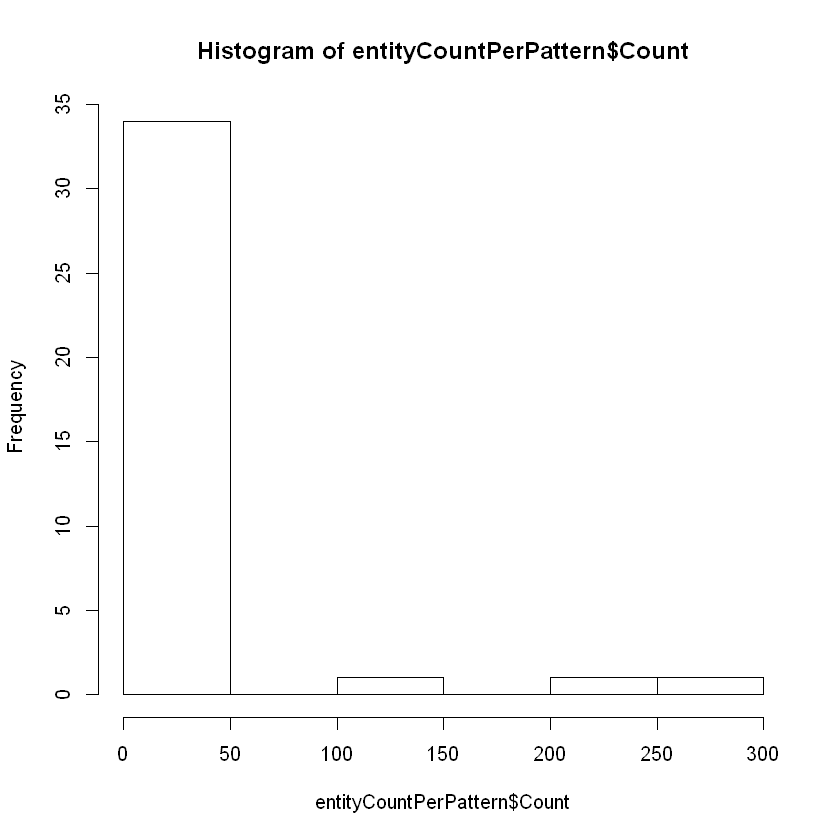

In [42]:
hist(entityCountPerPattern$Count)

We count all the entities per file.

And we can also draw a histogram of the counts.

In [43]:
entityCountPerFile=countMatchesPerRow(allEntities)
entityCountPerFile

,File,Count
1,cv000_29590.txt,25
2,cv001_18431.txt,4
3,cv002_15918.txt,1
4,cv003_11664.txt,2
5,cv004_11636.txt,2
6,cv005_29443.txt,1
7,cv006_15448.txt,1
8,cv007_4968.txt,1
9,cv008_29435.txt,2
10,cv009_29592.txt,1


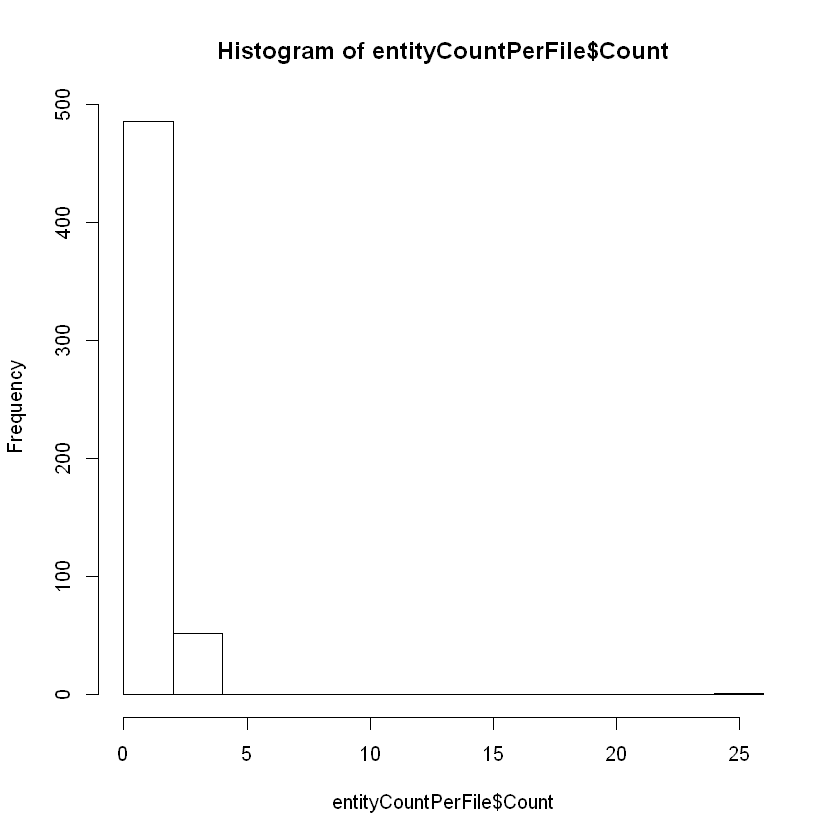

In [44]:
hist(entityCountPerFile$Count)

Write results to a file
We can write our results to a CSV file, sowe can use them in other places.

In [45]:
write.table(allEntities, file = "allEntities.csv", row.names = F, na="", sep=";")

Compare with a gold standard
Put all matches in a list for comparison with a gold standard.

In [46]:
allMatches = mergeAllMatchesInLists(allEntities)
head(allMatches)

Files,Matches
cv000_29590.txt,"alan moore , eddie campbell , terry hayes , rafael yglesias , peter deming , martin childs , moore , moore , campbell , campbell , jack , michael jackson , albert , allen hughes , arthouse crowd , peter godley, robbie coltrane , frederick abberline , johnny depp , mary kelly , mary kelly , steve guttenberg , heather graham , marilyn manson , tim burton , ians holm , joe gould , richardson"
cv001_18431.txt,"tracy flick , max fischer , _rushmore _, reese witherspoon , george washington carver , paul"
cv002_15918.txt,meg ryan
cv003_11664.txt,"martin brody , richard dreyfuss"
cv004_11636.txt,"jackie chan , barry sanders"
cv005_29443.txt,pascal nzonzi


Load the gold standard and put all gold standard matches in a list for comparison.

In [47]:
goldStandard = read.table(file = "goldStandard.csv", quote = "", na.strings=c(""),
                          colClasses="character", sep=";")
allMatchesGold = mergeGoldStandardInLists(goldStandard)
head(allMatchesGold)

Files,Matches
cv000_29590.txt,"alan moore , eddie campbell , moore , campbell , jack , michael jackson , albert , allen hughes , peter godley , robbie coltrane , frederick abberline, johnny depp , abberline , mary kelly , heather graham , terry hayes , rafael yglesias , steve guttenberg , tim burton , marilyn manson , peter deming , martin childs , depp , ians holm , joe gould , richardson , graham"
cv001_18431.txt,"matthew broderick , reese witherspoon , george washington carver, tracy flick , paul , max fischer , bill murray , broderick , witherspoon , jessica campbell , tammy , rooney , campbell , alexander payne , tracy , m"
cv002_15918.txt,"ryan , hanks , tom hanks , joe fox , meg ryan , kathleen kelley, fox , kelley"
cv003_11664.txt,"john williams , steven spielberg, spielberg , williams , martin brody , roy scheider , larry vaughn , murray hamilton , brody , matt hooper , richard dreyfuss, hooper , vaughn , quint , robert shaw , hitchcock , scheider , dreyfuss , shaw , robert redford , paul newman , duddy kravitz , ahab"
cv004_11636.txt,"herb , jackie chan , barry sanders , sanders , jackie , chan , bruce lee , tim allen , lawrence kazdan, john williams , spielberg , george lucas"
cv005_29443.txt,"raoul peck , lumumba , patrice lumumba , eriq ebouaney , helmer peck , peck , pascal bonitzer , patrice , joseph kasa vubu, maka kotto , moise tschombe , pascal nzonzi"


Calculate the metrics (precision, recall, f-measure).

In [48]:
metrics = calculateMetrics(allMatches, allMatchesGold)
metrics

Precision,Recall,Fmeasure
0.5829327,0.03632143,0.06838209


Now we calculate the metrics for the original pattern2

In [49]:
allEntities2 = detectPatternsInTaggedCorpus(corpus, corpus.taggedText, pattern2)
allMatches2 = mergeAllMatchesInLists(allEntities2)
metrics2 = calculateMetrics(allMatches2, allMatchesGold)
metrics2

Precision,Recall,Fmeasure
0.8181818,0.003370029,0.006712411


We can appreciate that the precision is lower with patter3, this is because by including way more patterns we are also including a lot of words that are not proper nouns, and because of that the precision decreases.

On the other hand, recall and Fmeasure increases because the search is more exhaustive. Nevertheless there are way more patterns that the ones we included and each document is written by a different person in a different way and about a different movie. That is why is a complex task to find the names.

It could be interesting to try use a more complex POS Tagger in order that identifies proper names, or at least that have more specific tags to help us to look for the names.